# House Prices: Predictive Model Example


This notebook is the second part of the house price modeling and is a more simplified version of it. We worked with fewer features than the original dataset and simplified feature engineering and data preprocessing steps that are in the other notebook for more detail. The goal is to be able to quickly get to training a model and see the potential of the model and applications.

This is a very basic example of ML predictive modeling, addressing the fundamental stages of an analytics problem. In this case we will explore the popular "house prices" dataset, a core competency of the kaggle platform, to understand the fundamental stages in developing a predictive model.

It includes the following approaches and techniques:

- EDA (Exploration Data Analysis)
- Understanding correlation between features and targets
- Data Wrangling, convert categorical to numerical
- Apply the basic Multivariate Regression models (model selection)
- Model Understanding and interpretation


In case you only want to see the model creation and interpretation stage, skip to 9 part Model Development stage.




# 0. Summary

This exercise is to show the potential of predictive models and the influence they can have on decision making.

Through a method we were able to generate a model that could present good generalization and quite good performance, considering the that we are using the simplest model,  which results in an error of 12%, without applying advanced feature engineering techniques or more advanced machine learning models. The interpretability of the model and the impact it could have on future business decisions are evaluated.

The big challenge was the proper detection and decision-cutting of outliers, the reassessment of noise-generating features, and the combined combination of selection and data engineering strategies.

We can put into practice a great number of techniques and methods, from EDA to the generation of stacked models, covering a broad conceptual and practical expectation as desired.

We determined that the area and quality of construction material are the most significant factor on house prices, over Zones or Neighborhood, things that intuitively make sense be the most important (**for this specific model**)

If we wanted to increase the valuation of the houses, I would look for an economic trade off between quality of building material and the area available to make the houses, as shown in the following parallel plot, medium área and high quality, give us a high house price, to interpret the solution !!

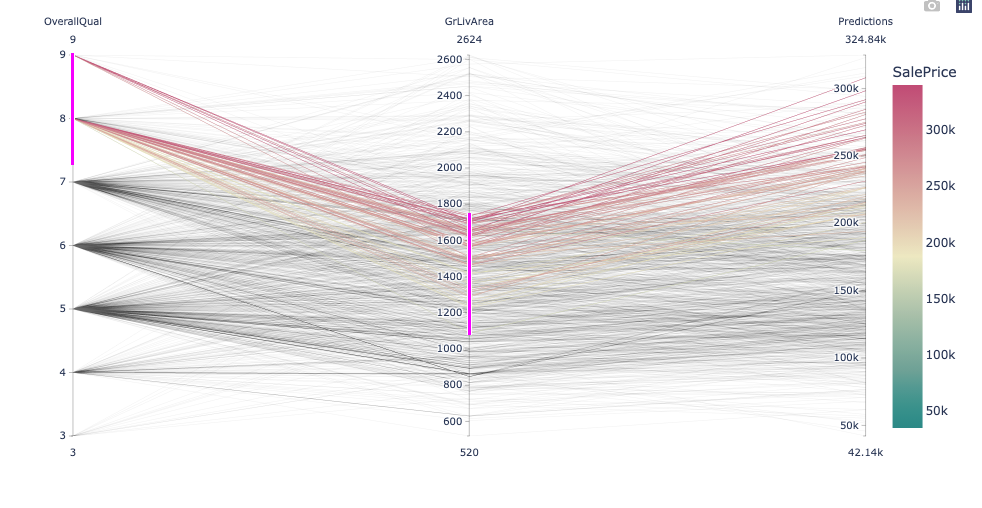




# 1. Basic Math Concetps

### Numerical vs Categorical Data
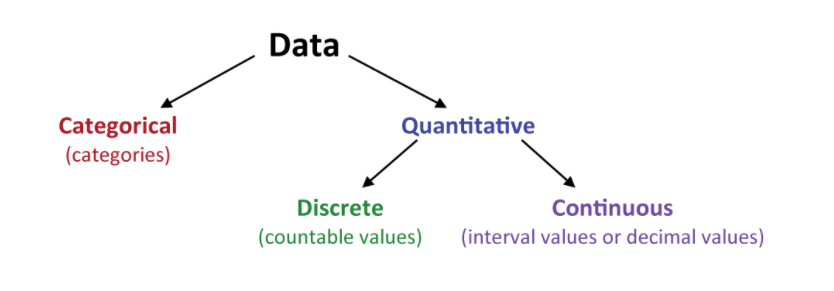


### Dependent and Independent Variables

In research, variables are any characteristics that can take on different values, such as height, age, species, or exam score.

In scientific research, we often want to study the effect of one variable on another one. For example, you might want to test whether students who spend more time studying get better exam scores.

The variables in a study of a cause-and-effect relationship are called the independent and dependent variables.

- The independent variable is the cause. Its value is independent of other variables in your study --> Model Features
- The dependent variable is the effect. Its value depends on changes in the independent variable --> Model Target 

We want to understand how independent variables affects dependent variables


### Correlation of variables

Pearson's correlation coefficient (r) is a measure of linear correlation between two variables. Its value is between -1 and +1, -1 indicating a total negative linear correlation, 0 indicating no linear correlation, and 1 indicating a total positive linear correlation. In addition, r is invariant under separate changes in the location and scale of the two variables, implying that for a linear function the angle with the x-axis does not affect r.

So we need higth correlation between features and target, and low correlation between the features, that we selected


### Multicollinearity

Occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results. So in this example we are going to avoid this situation

### Outliers

Outliers are unusual values in your dataset, and they can distort statistical analyses and violate their assumptions. Unfortunately, all analysts will confront outliers and be forced to make decisions about what to do with them. Given the problems they can cause, you might think that it’s best to remove them from your data. But, that’s not always the case. Removing outliers is legitimate only for specific reasons.

A graph that displays an outlier.Outliers can be very informative about the subject-area and data collection process. It’s essential to understand how outliers occur and whether they might happen again as a normal part of the process or study area. Unfortunately, resisting the temptation to remove outliers inappropriately can be difficult. Outliers increase the variability in your data, which decreases statistical power. Consequently, excluding outliers can cause your results to become statistically significant.



### Multivariate Regression

Multivariate Regression is a method used to measure the degree at which more than one independent variable (predictors) and more than one dependent variable (responses), are linearly related. The method is broadly used to predict the behavior of the response variables associated to changes in the predictor variables, once a desired degree of relation has been established.


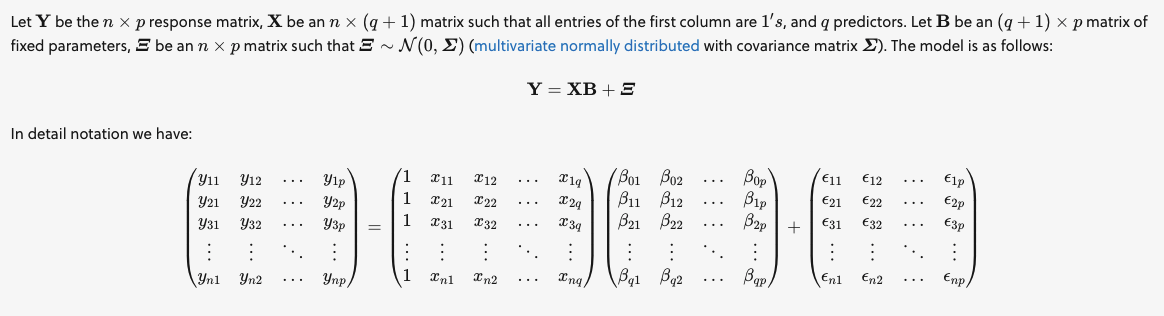


# 2. Import libraries

In [ ]:
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from numpy import arange
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
%matplotlib inline
warnings.filterwarnings("ignore")


# 3. Import Data

In [ ]:
# import data from .csv file
data = pd.read_csv("data/data_cleaned.csv")

In [ ]:
# shows first 10 rows on data
data.head(10)

In [ ]:
# show data dimensions
data.columns

# 4. Data Description

Here's a brief version of what you'll find in the data description file [data_description.txt].

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- OverallQual: Overall material and finish quality
- GrLivArea: Above grade (ground) living area square feet
- GarageCars: Size of garage in car capacity
- TotalBsmtSF: Total square feet of basement area
- BsmtFullBath: Basement full bathrooms
- FullBath: Full bathrooms above grade
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- MasVnrArea: Masonry veneer area in square feet
- Fireplaces: Number of fireplaces
- MSZoning: The general zoning classification
- Neighborhood: Physical locations within Ames city limits
- Condition2: Proximity to main road or railroad (if a second is present)
- MasVnrType: Masonry veneer type
- ExterQual: Exterior material quality
- BsmtQual: Height of the basement
- CentralAir: Central air conditioning
- Electrical: Electrical system
- KitchenQual: Kitchen quality
- SaleType: Type of sale



# 5. Exploration Data Analysis

In [ ]:
# Numerical and categorical features
numerical_feats = data.dtypes[data.dtypes != "object"].index
categorical_feats = data.dtypes[data.dtypes == "object"].index

In [ ]:
numerical_feats

In [ ]:
categorical_feats

## 5.1 Understanding Distributions and correlations

This graph shows two plots within the numerical columns.

Diagonal: Histogram that has the distributions of each variable, where we can make assumptions about it (normal, binomial, poisson, etc).

Matrix: Correlation plots, you can see each variable graphed with respect to the other, the most interesting to observe is the first column of graphs that shows all the features vs target (SalePrice). 

These plots allow us to understand ranges in which a variable moves, relationships between them, etc.

For example, strong linear correlation between GrLivArea, YearBuilt, TotalBsmtSF (among others) and SalePrice 



In [ ]:
sns.pairplot(data)

In [ ]:
def plot_corr_matrix(df, nr_c, targ) :
    """
    Create correlation matrix to understand relation with target
    """
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

target = "SalePrice"
nr_feats = len(data.columns)
plot_corr_matrix(data, nr_feats, target)

## 6.1 Conclusion from EDA on numerical columns:

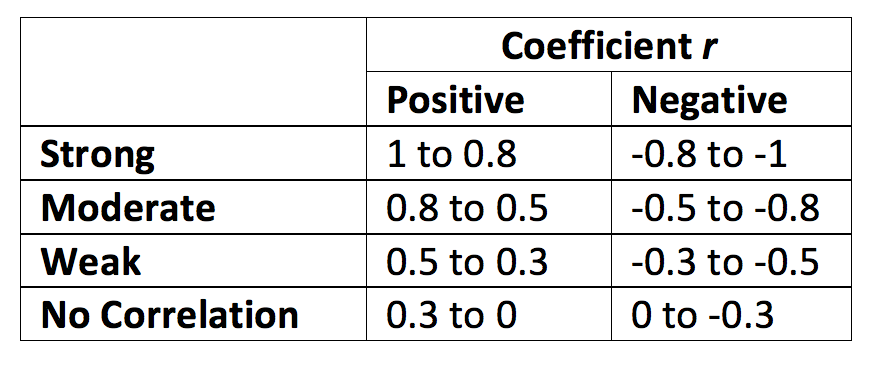

We see that for some features like 'OverallQual' there is a strong linear correlation (0.77) to the target.

For this kernel I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice. For this case we have only moderate correlation beetween features, so we are going to keep all numerical features.






In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 5
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*10, nr_rows*5))
for r in range(0, nr_rows):
    for c in range(0, nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            plt.xticks(rotation=80)
            plot = sns.boxplot(x=li_cat_feats[i], y=target, data=data, ax = axs[r][c])
            plt.setp(plot.get_xticklabels(), rotation=75)
plt.tight_layout()    
plt.show()   


## 6.2 Conclusion from EDA on categorical columns:

For many of the categorical there is no strong relation to the target.
However, for some fetaures it is easy to find a strong relation.

**How do we know that a categorical feature provides predictive value to the target? When category distributions are disjoint for all categories in the feature.**

From the figures above these are : 'MSZoning', BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType' Also for the categorical features, I use only those that show a strong relation to SalePrice. However, by way of this example we will leave all the features,



# 7. Categorical to numerical values

Data Preprocessing is a very crucial step in every Machine learning model creation because the independent and dependent features should be as linearly aligned as possible i.e. the independent features should be separated as such that proper association can be made with the target feature such that the model accuracy gets increased. By Data Preprocessing we mean scaling the data, changing the categorical values to numerical ones, normalizing the data, etc. Today we will be discussing encoding the categorical variables into numeric ones using encoding techniques and will learn the differences between the different encodings. The programming language that we are taking here for reference is Python. Different encoding techniques that are present for preprocessing the data are **One Hot Encoding** and **Label Encoding**. Let us understand these two, one by one and try to learn the difference between the two:


- **Label Encoding**:
This is a data preprocessing technique where we try to convert the categorical column data type to numerical (from string to numeric). This is done because our machine learning model doesn’t understand string characters and therefore there should be a provision to encode them in a machine-understandable format. This is achieved with the Label Encoding method. In the Label Encoding method, the categories present under the categorical features are converted in a manner that is associated with hierarchical separation. This means that if we have categorical features where the categorical variables are linked with each other in terms of hierarchy then we should encode these features using Label Encoding. If Label Encoding is performed on non-hierarchical features then the accuracy of the model gets badly affected and hence it is not a good choice for non-hierarchical features.


- **One Hot Encoding**:
This is also an encoding technique in the field of Machine Learning where we try to convert the categorical string variables to numeric ones. The way it converts these features to numeric is very interesting. It creates dummy variables in the data which corresponds to the categorical variables. This means that each categorical feature is assigned a dummy column. The dummy columns are nothing but One Hot Vector in the n-dimensional space. This type of encoding technique is best suited for non-hierarchical features where there is no link of one variable with others. We can say that it is opposite to Label Encoder in the way it works. But, there is a drawback of One Hot Encoding which is also called Dummy Variable Trap. This means that the variables are highly correlated to each other and leads to multicollinearity issues. By multicollinearity, we mean dependency between the independent features and that is a problem. To avoid this kind of problem we drop one of the dummy variable columns and then try to execute our Machine learning model.

**In this example for simplicity (less features), we will do label encoding.**




In [ ]:
categorical_feats

In [ ]:
all_data = data.copy()
le = preprocessing.LabelEncoder()
for col in categorical_feats:
    print(col)
    all_data[col] = le.fit_transform(all_data[col].values)

In [ ]:
all_data

# 8. Model development

## 8.1 Problem definition

We define our problem, identified features (independent variables) and model target (dependen variables), create a features matrix and target vector


In [ ]:
features = list(all_data.columns)
features.remove("SalePrice")
features

In [ ]:
target = ["SalePrice"]
target

In [ ]:
# Model features
X = all_data[features]
# Model Target
y = all_data[target]

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
std_features = all_data.describe()
std_features.reset_index(drop=False, inplace=True)
std_features = std_features[std_features["index"] == "std"]
std_features.drop(columns=["index"], inplace=True)
std_features.reset_index(drop=True, inplace=True)
std_features = std_features.T
std_features.reset_index(drop=False, inplace=True)
std_features.columns = ["features", "std"]
std_features

In [ ]:
mean_features = all_data.describe()
mean_features.reset_index(drop=False, inplace=True)
mean_features = mean_features[mean_features["index"] == "mean"]
mean_features.drop(columns=["index"], inplace=True)
mean_features.reset_index(drop=True, inplace=True)
mean_features = mean_features.T
mean_features.reset_index(drop=False, inplace=True)
mean_features.columns = ["features", "mean"]
mean_features

## 8.2 Standarize our data


**Data standardization** is this process of making sure that your data set can be compared to other data sets. It’s a key part of research, and it’s something that everyone who uses data should consider before they even collect, clean, or analyze their first data point.

**What is data standardization exactly?**
Data standardization is about making sure that data is internally consistent; that is, each data type has the same content and format.

Standardized values are useful for tracking data that isn’t easy to compare otherwise.

For example, suppose you and your friend went to different universities. One day, you both got your midterm grades for your Physics 101 classes. Your professor sticks to the normal grading scale (out of 100), so you got a grade of 84; the test has a mean of 77 and a standard deviation of 6. Your friend’s professor, though, uses his own grading scale, so she got a grade of 452. Her test has a scale of 750, mean of 400, and standard deviation of 100.

Both of you scored above average, but who did better? While the main data points might not be immediately comparable, there is a way to standardize and compare the data points. Converting them to percentages shows that you came out ahead, with an 84% compared to your friend’s 60%.






In [ ]:
sc = StandardScaler()
# training
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns=features)

## 9.3 Train-Test Split Evaluation


The train-test split is a technique for evaluating the performance of a machine learning algorithm.

It can be used for classification or regression problems and can be used for any supervised learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the fit machine learning model.

In this example we are going to train with 976 observations and testing our algorithms with 244 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [ ]:
print("Training Features dimentions:", X_train.shape)
print("Testing Features dimentions:", X_test.shape)

## 8.4 Model selection

The best model is not always the most complicated. Sometimes including variables that are not evidently important can actually reduce the accuracy of predictions. In this section we do model selection looking best results over diferents model hyperparameters


In [ ]:
# define model evaluation method
ratios = arange(0, 1, 0.005)
alphas = np.logspace(-10, 2, 100)
fit_intercept = [True, False]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, fit_intercept=fit_intercept, n_jobs=3)
# fit model
model = model.fit(X_train, y_train)

In [ ]:
# Choosen hupyerparams
alpha = model.alpha_
l1_ratio = model.l1_ratio_
coeficients = model.coef_
intercept = model.intercept_
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)
print('coeficients:', coeficients)
print('intercept:', intercept)

## 8.5 Model Training

In [ ]:
regression_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)

In [ ]:
regression_model = regression_model.fit(X_train, y_train)

In [ ]:
# summarize chosen configuration
coeficients = regression_model.coef_
intercept = regression_model.intercept_
# summarize chosen configuration
print('coeficients:', coeficients)
print('intercept:', intercept)

## 8.6 Model Evaluation

### 8.6.1 Model Predictions

In [ ]:
# Model inference (predictions)
y_pred = regression_model.predict(X_test)

# Reshape vector to have same dimensions
y_pred = np.reshape(y_pred,(-1, 1)) 
y_test = np.reshape(y_test,(-1, 1)) 

### 8.6.2 Results Visualization

In [ ]:
def plot_xy_results(y_pred, y_test, name="Regularized Regression"):
    """
    Plot sequence de la secuecnia

    Parameters
    ----------
    predictions : array
        predicciones.
    real : array
        valores reales.
    fechas : array
        array de fechas.
    indice : TYPE
        indice de la columna.
    
    Returns
    -------
    plot de prediciones vs real.
    
    """
    letter_size = 20
    mae = np.abs(y_pred - y_test).mean()
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = str(round(mae, 4))
    mape = str(round(mape, 4))
    mse = str(round(mse, 4))
    rmse = str(round(rmse, 4))
    r2 = str(round(r2, 4))

    fig, ax = plt.subplots(1, figsize=(22, 12))
    plt.scatter(y_test, y_test, color='red')
    plt.scatter(y_test, y_pred, color='k')
    title = f"{name}" + "\n" + f"R2: {r2}" + "\n" + f"MAPE: {str(mape)}" + "\n" + f"MAE: {str(mae)}"
    plt.title(title, fontsize=30)
    plt.xlabel('Real', fontsize=30)
    plt.ylabel('Predictions', fontsize=30)
    plt.grid(color='silver', linestyle='-', linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(['Real', 'Prediction'], loc='upper left',
               prop={'size': letter_size+5})
    plt.show()

In [ ]:
plot_xy_results(y_pred, y_test, name="Multivariate Regression Model")

### 8.6.3 Metrics evaluation

In [ ]:
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred) * 100

mape = str(round(mape, 4))
mse = str(round(mse, 4))
rmse = str(round(rmse, 4))
r2 = str(round(r2, 4))

print("MAPE:", mape, "[%]")
print("R2:", r2, "[%]")
print("MEAN ABSOLUTE ERROR:", "$", mae)
print("MEAN SQUARED ERROR:", "$**2", mse)
print("ROOT MEAN SQUARED ERROR:", "$", rmse)

**An average error of $ 19.199 is obtained on a variable with an average of 166.000, an error of 12%.
Pretty good model, considering that we are using the basic techniques of feature engineering and the most basic model in Machine Learning, these errors can be lowered, using other advanced algorithms (bagging and boosting methods, SVM, Neural nets, etc), in which it has been proven to reach 5% Mean percentage error**

## 8.7 Model Interpretation

Interpreting Regression Coefficients for Linear Relationships
The sign of a regression coefficient tells you whether there is a positive or negative correlation between each independent variable and the dependent variable. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.

The coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable while holding other variables in the model constant. This property of holding the other variables constant is crucial because it allows you to assess the effect of each variable in isolation from the others.


In [ ]:
feats = pd.DataFrame(X_test.columns, columns=["features"])
coeficients = pd.DataFrame(coeficients, columns=["coeficients"])

### 9.7.1 To read this coeficients take:
**A change of 1 standard deviation in X is associated with a change of β standard deviations of Y**


In [ ]:
interpret = pd.concat([feats, coeficients], axis=1)
interpret["coeficients_abs"] = interpret["coeficients"].apply(abs)
interpret.sort_values(by=["coeficients_abs"], ascending=False, inplace=True)
interpret.reset_index(drop=True, inplace=True)
interpret = interpret.merge(std_features, on=["features"], how="outer")
interpret = interpret.merge(mean_features, on=["features"], how="outer")
interpret

In [ ]:
predictions = regression_model.predict(X)
predictions = np.reshape(predictions, (-1, 1)) 
all_data["Predictions"] = predictions

**The following features were the most important and have the greatest impact on the models.**

- GrLivArea: Above grade (ground) living area square feet
- OverallQual: Overall material and finish quality
- TotalBsmtSF: Total square feet of basement area

We determined that the area and quality of construction material are the most significant factor on house prices, over Zones or Neighborhood, things that intuitively make sense be the most important (but not).

If we wanted to increase the valuation of the houses, I would look for an economic trade off between quality of building material and the area available to make the houses, as shown in the following parallel plot, medium área and high quality, give us a high house price, to interpret the solution !!plot, **medium área and high quality, give us a high house price !!**


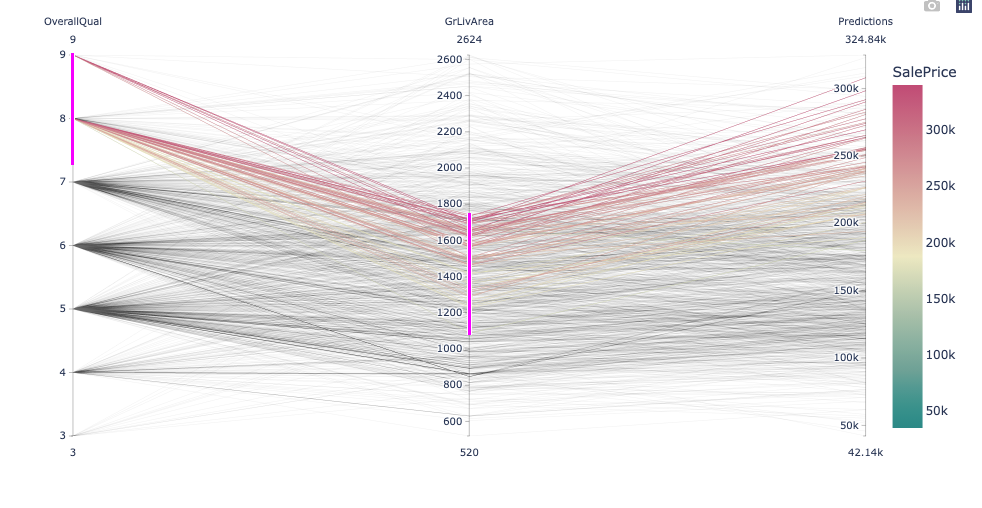

### 8.7.2 Parallel plot, model understanding

In [ ]:
fig = px.parallel_coordinates(all_data, color="SalePrice",
                              dimensions=['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'Predictions'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

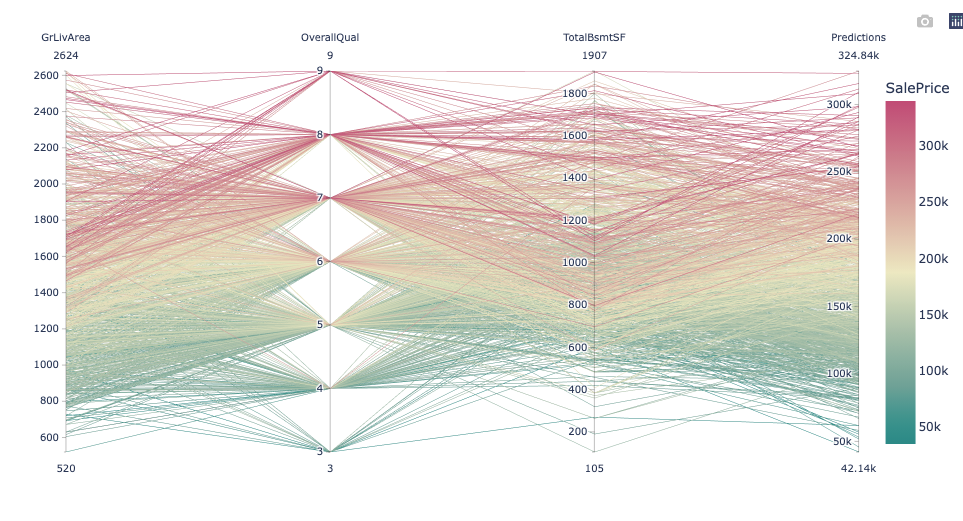

# 10. EXTRA: Using a Boosting Machine learning model

Go deeper on ML models and predictive power.

In [ ]:
params = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5,
               'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:squarederror'}

In [ ]:
xgb_model = XGBRegressor(**params)

In [ ]:
xgb_model = xgb_model.fit(X_train, y_train)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred) * 100

mape = str(round(mape, 4))
mse = str(round(mse, 4))
rmse = str(round(rmse, 4))
r2 = str(round(r2, 4))

print("MAPE:", mape, "[%]")
print("R2:", r2, "[%]")
print("MEAN ABSOLUTE ERROR:", "$", mae)
print("MEAN SQUARED ERROR:", "$**2", mse)
print("ROOT MEAN SQUARED ERROR:", "$", rmse)

In [ ]:
plot_xy_results(y_pred, y_test, name="XGBoost")

In [ ]:
# compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)